In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-02-21 12:46:44.122768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 12:46:44.212445: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 12:46:44.216624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 12:46:44.216633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
#The model itself

input_shape = (224, 224, 3)

model = Sequential()
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(512, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2023-02-21 12:46:45.850150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 12:46:45.850169: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 12:46:45.850200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lars-ThinkPad-P15-Gen-2i): /proc/driver/nvidia/version does not exist
2023-02-21 12:46:45.850397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Loading the dataset

dataset_path = "/home/lars/Documents/Datasets/StrawDI_image_regression"
labels_file = dataset_path + "/labeling_annotation.pkl"

#Open up and read the pickle file
with open(labels_file, 'rb') as f:
    labels = pickle.load(f)
    #Covert to a pandas dataframe
    df = pd.DataFrame(labels)
    
df

,filename,label
0,2085_6.png,4
1,1450_10.png,98
2,2298_3.png,23
3,2840_1.png,67
4,2396_6.png,-1
...,...,...
17046,2867_3.png,NaN
17047,2212_8.png,NaN
17048,2839_4.png,NaN
17049,914_0.png,NaN


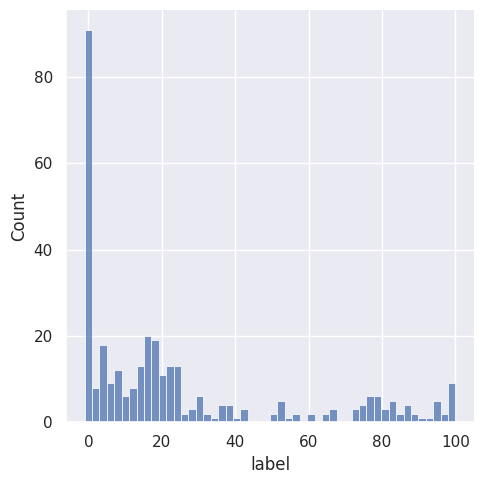

In [4]:
sns.set_theme(style="darkgrid")
#Plotting the distribution of the labels with bins = 50, going from -10 to 100
sns.displot(df, x="label", bins=50)

In [5]:
#First we want to remove any images that are not labeles or have a label of -1
df = df[df.label != -1]

#Removing all the rows that has NaN values for the label
df = df.dropna(subset=['label'])

#We need to get the indexes back to normal, i.e no gaps
df = df.reset_index(drop=True)

images = []
for index, row in df.iterrows():
    #Try to open the image
    img = Image.open(dataset_path + "/images/" + row['filename'])
    images.append(img)

additional = pd.DataFrame(images, columns=['image'])

df = pd.concat([df, additional], axis=1)
df

,filename,label,image
0,2085_6.png,4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,1450_10.png,98,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,2298_3.png,23,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,2840_1.png,67,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,617_6.png,20,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
249,2334_2.png,14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
250,1004_6.png,75,<PIL.PngImagePlugin.PngImageFile image mode=RG...
251,443_1.png,16,<PIL.PngImagePlugin.PngImageFile image mode=RG...
252,263_0.png,90,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [6]:
import matplotlib.pyplot as plt
#Checking that the Image object is in fact the same as the image from the filename

""" for i in range(10):
    img = Image.open(dataset_path + "/images/" + df['filename'][i])
    #Plot side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(df['image'][i])
    ax[1].imshow(img)
    plt.show() """



' for i in range(10):\n    img = Image.open(dataset_path + "/images/" + df[\'filename\'][i])\n    #Plot side by side\n    fig, ax = plt.subplots(1, 2)\n    ax[0].imshow(df[\'image\'][i])\n    ax[1].imshow(img)\n    plt.show() '

In [6]:
# x is the features, i.e the images as np arrays
x = []

for i in range(len(df)):
    df['image'].iloc[i] = df['image'][i].resize((224, 224), Image.ANTIALIAS)
    ar = np.array(df['image'].iloc[i])
    x.append(ar)
x = np.asarray(x)

""" #Just showing the pictures after anti-aliasing and resizing
for i in range(10):
    plt.imshow(x[i])
    plt.show() """

' #Just showing the pictures after anti-aliasing and resizing\nfor i in range(10):\n    plt.imshow(x[i])\n    plt.show() '

In [7]:
y = df['label']
#Convert the second column to ints
y = y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [8]:
datagen = ImageDataGenerator(
    rescale=1./255., width_shift_range = 0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train = datagen.flow(x_train, y_train, batch_size=16)

test = test_datagen.flow(x_test, y_test, batch_size=16)

In [9]:
model.fit(train, epochs=20, validation_data=test)

#Get the current date and time
from datetime import datetime
now = datetime.now()
#Convert to string
now = now.strftime("%d-%m-%Y_%H")

#Not totally sure if this works
model.save("ripeness_model{}.h5".format(now))

Epoch 1/20
13/13 [==============================] - 12s 922ms/step - loss: 4013.3406 - mae: 42.7754 - val_loss: 1655.6798 - val_mae: 28.7287
Epoch 2/20
13/13 [==============================] - 12s 906ms/step - loss: 1208.8837 - mae: 27.0504 - val_loss: 727.6465 - val_mae: 18.4940
Epoch 3/20
13/13 [==============================] - 12s 925ms/step - loss: 635.4315 - mae: 21.0651 - val_loss: 211.6264 - val_mae: 12.8084
Epoch 4/20
13/13 [==============================] - 12s 910ms/step - loss: 162.2382 - mae: 8.9858 - val_loss: 90.2387 - val_mae: 6.7178
Epoch 5/20
13/13 [==============================] - 12s 932ms/step - loss: 147.1107 - mae: 8.2182 - val_loss: 146.9912 - val_mae: 8.3498
Epoch 6/20
13/13 [==============================] - 12s 940ms/step - loss: 129.8940 - mae: 7.8453 - val_loss: 92.7389 - val_mae: 7.2671
Epoch 7/20
13/13 [==============================] - 12s 920ms/step - loss: 153.6622 - mae: 8.3670 - val_loss: 128.3008 - val_mae: 7.5430
Epoch 8/20
13/13 [================

AttributeError: 'NoneType' object has no attribute 'format'

In [10]:
model.save("ripeness_model_{}.h5".format(now))

In [17]:
from keras.models import load_model
model = load_model("ripeness_model.h5")

In [12]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((224,224), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((224,224), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((224,224), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 224, 224, 3)
    
    age = model.predict(ar)
   
    print('Age:', int(age))
    return im.resize((224,224), Image.ANTIALIAS)

1/1 [==============================] - 0s 45ms/step
Age: 17


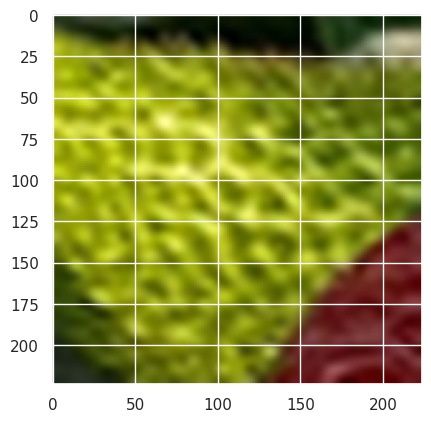

1/1 [==============================] - 0s 43ms/step
Age: 56


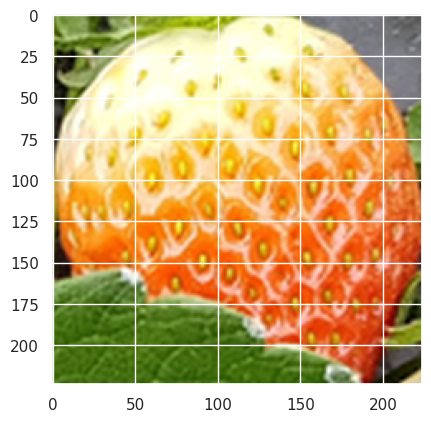

1/1 [==============================] - 0s 43ms/step
Age: 21


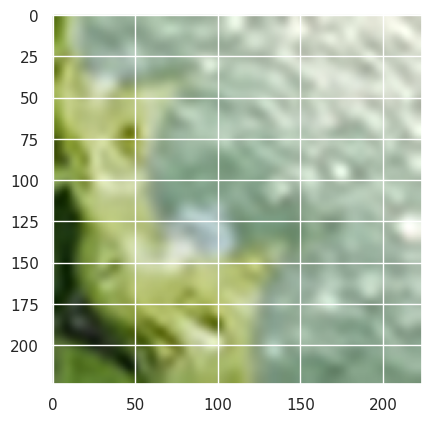

1/1 [==============================] - 0s 45ms/step
Age: 23


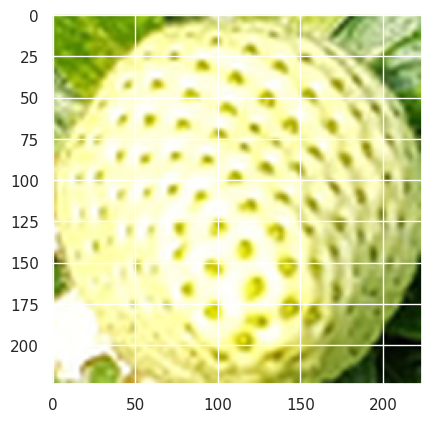

1/1 [==============================] - 0s 40ms/step
Age: 29


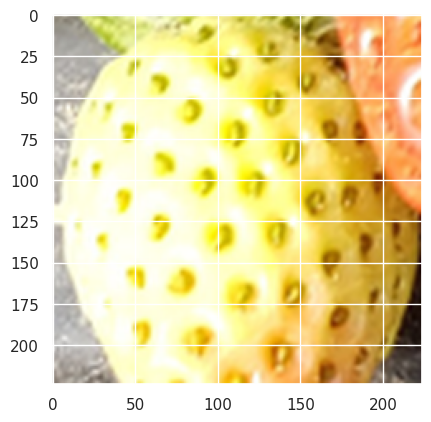

1/1 [==============================] - 0s 43ms/step
Age: 21


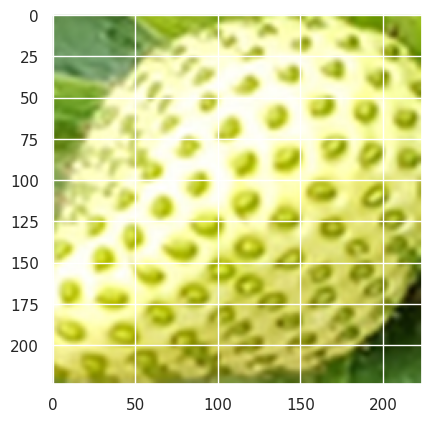

1/1 [==============================] - 0s 38ms/step
Age: 75


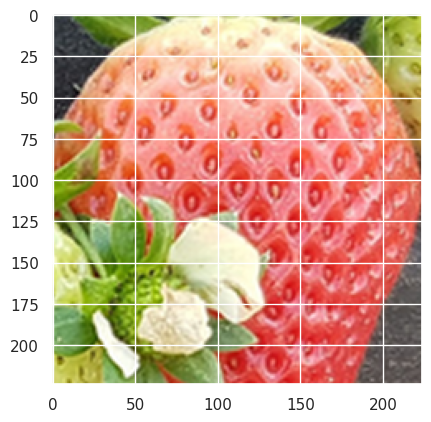

1/1 [==============================] - 0s 45ms/step
Age: 19


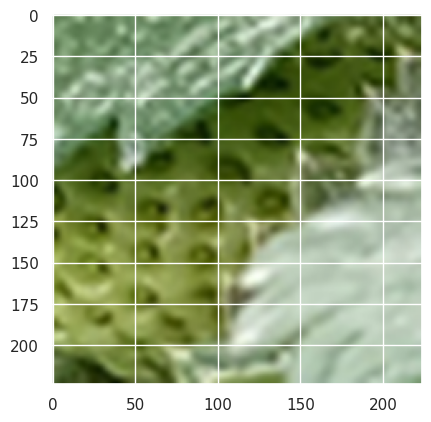

1/1 [==============================] - 0s 45ms/step
Age: 12


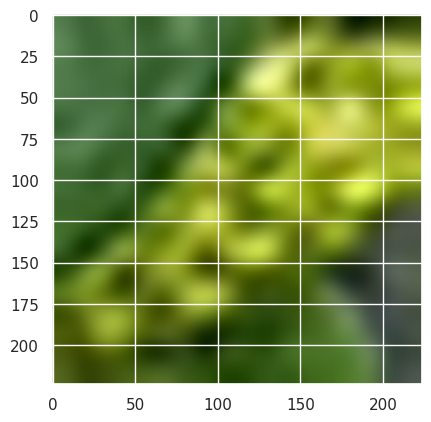

1/1 [==============================] - 0s 42ms/step
Age: 15


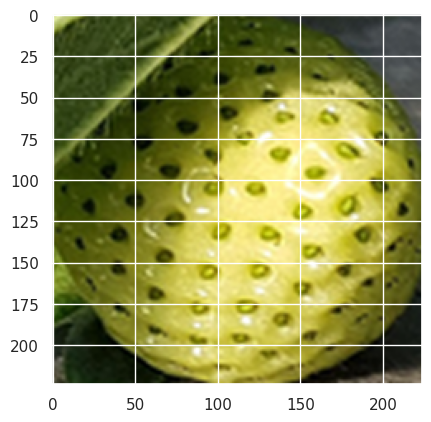

1/1 [==============================] - 0s 44ms/step
Age: 45


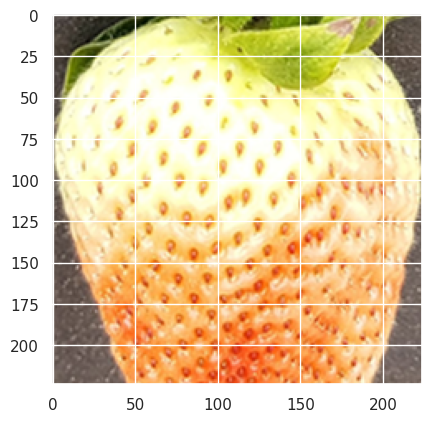

1/1 [==============================] - 0s 39ms/step
Age: 54


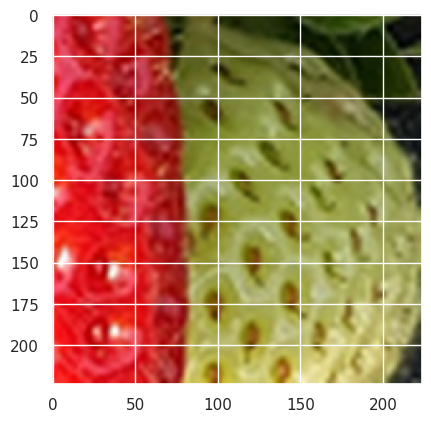

1/1 [==============================] - 0s 38ms/step
Age: 17


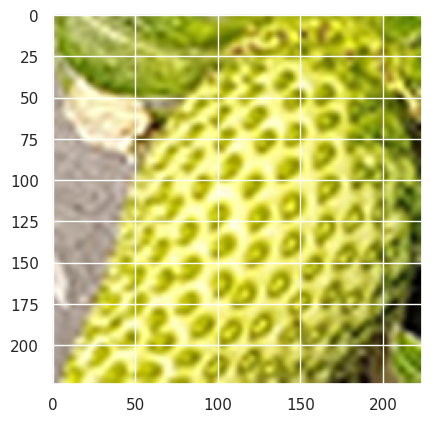

1/1 [==============================] - 0s 40ms/step
Age: 23


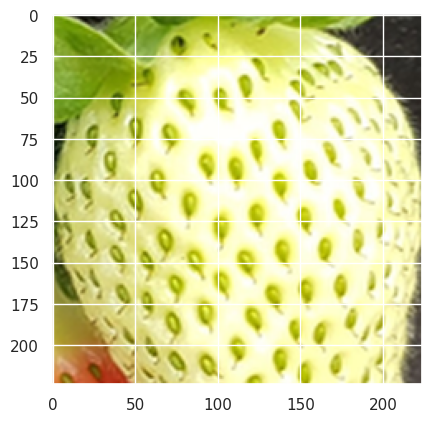

1/1 [==============================] - 0s 44ms/step
Age: 18


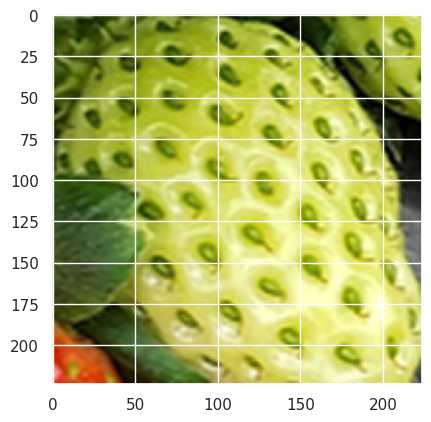

In [14]:
#Taking the first 15 pictures in the dataset and predicting the ripeness whilst 
 # displaying them with matplotlib
import matplotlib.pyplot as plt

for i in os.listdir(dataset_path + "/images/")[1000:1015]:
    im = process_and_predict(dataset_path + "/images/" + i)
    plt.imshow(im)
    plt.show()